In [1]:
import xmitgcm
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
import scipy
from matplotlib import pyplot as plt 
import cartopy as cart
import pyresample
import pandas as pd
import nc_time_axis


from mpl_toolkits.mplot3d import Axes3D 
from scipy import interpolate
import scipy.io as sio

import warnings; warnings.simplefilter('ignore')

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, -54, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, projection=cart.crs.SouthPolarStereo(), lon_0=-60, **plt_kwargs):

        assert set(da.dims) == set(['j', 'i']), "da must have dimensions ['j', 'i']"

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})
        else:
            m = plt.axes(projection=projection)

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.fillna(0).values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)
        field1 = pyresample.kd_tree.resample_nearest(self.orig_grid, coords1.Depth.fillna(0).values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())

        x,y = self.new_grid_lon, self.new_grid_lat

        # Find index where data is splitted for mapping
        split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))


        p = ax.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=1, **plt_kwargs)
        p = ax.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=2, **plt_kwargs)
        p1 = ax.contour(x[:,:split_lon_idx], y[:,:split_lon_idx], field1[:,:split_lon_idx],
                         [1000], colors='black',transform=cart.crs.PlateCarree(), zorder=1)
        p1 = ax.contour(x[:,split_lon_idx:], y[:,split_lon_idx:], field1[:,split_lon_idx:],
                         [1000], colors='black',transform=cart.crs.PlateCarree(), zorder=2)
        p2 = ax.contourf(x[:,:split_lon_idx], y[:,:split_lon_idx], field1[:,:split_lon_idx],
                         [0, 1], colors='grey',transform=cart.crs.PlateCarree(), zorder=1)
        p2 = ax.contourf(x[:,split_lon_idx:], y[:,split_lon_idx:], field1[:,split_lon_idx:],
                         [0, 1], colors='grey',transform=cart.crs.PlateCarree(), zorder=2)
        #ax.add_feature(cart.feature.LAND, facecolor='0.5', zorder=3)
        ax.set_extent([-180, 180, -90, -64], cart.crs.PlateCarree())
        #ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='black',linestyle=':')
        label = ''
        if da.name is not None:
            label = da.name
        if 'units' in da.attrs:
            label += ' [%s]' % da.attrs['units']
        cb = plt.colorbar(p, shrink=0.8, label=label)
        return ax

In [2]:
from dask_jobqueue import SGECluster


cluster = SGECluster(cores=1,memory="6GB", interface="ib0",
             queue="Analysis3.q",
             walltime="02:00:00")

cluster.scale(10)
  
from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SGECluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.2.1.7:37877,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
cluster

Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.2.1.7:37877,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
cluster.close()

In [4]:
# do for CM4 sims
#datadir1 = '/jbod/myoungs/MITgcm_SO/experiments_mky/llc270_notides_CM4pI_cycle2_a/results/diags/'
datadir1 = '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4pI_cycle3/results/diags/'
datadir2 = '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4SSP/results/diags/' 
#datadir2 = '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_notides_ref_Ruth/results/diags/' 
griddir =  '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4pI_cycle3/results/' 

dspI = xmitgcm.open_mdsdataset(datadir1,grid_dir=griddir,prefix=['state_2d_set1','layers_3d_set2','fluxes_3d_set1','trsp_3d_set1','state_3d_set1']
                             ,geometry='curvilinear',delta_t = 1200,ref_date='0000-12-31',calendar='noleap')
#dspI = dspI.assign_coords(time=(dspI.time+np.datetime64("1992-12-31")))
#dsSSP = dsSSP.assign_coords(time=(dsSSP.time+np.datetime64("1992-12-31"))) # 2075
grid = xgcm.Grid(dspI, periodic=False)

In [5]:
coords1 = dspI.coords.to_dataset().reset_coords()
mapper1 = LLCMapper(coords1)

dspI

<xarray.Dataset>
Dimensions:   (i: 1080, i_g: 1080, j: 310, j_g: 310, k: 113, k_u: 113,
               k_l: 113, k_p1: 114, time: 227, _UNKNOWN_: 123)
Coordinates: (12/49)
  * i         (i) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * j         (j) int64 0 1 2 3 4 5 6 7 8 ... 302 303 304 305 306 307 308 309
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 ... 302 303 304 305 306 307 308 309
  * k         (k) int64 0 1 2 3 4 5 6 7 8 ... 105 106 107 108 109 110 111 112
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 ... 105 106 107 108 109 110 111 112
    ...        ...
    rLowW     (j, i_g) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rhoRef    (k) >f4 dask.array<chunksize=(113,), meta=np.ndarray>
    rSurfC    (j, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rSurfW    (j, i_g) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) object 0001-01-31 00:00:00 ... 0019-11-30 00:00:00
Dimensions without coordinates: _UNKNOWN_
Data variables: (12/68)
    ETAN      (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIarea    (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIheff    (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIhsnow   (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SItices   (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIuice    (time, j, i_g) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    ...        ...
    LaVH1RHO  (time, _UNKNOWN_, j_g, i) float32 dask.array<chunksize=(1, 123, 310, 1080), meta=np.ndarray>
    LaHw1RHO  (time, _UNKNOWN_, j, i_g) float32 dask.array<chunksize=(1, 123, 310, 1080), meta=np.ndarray>
    LaHs1RHO  (time, _UNKNOWN_, j_g, i) float32 dask.array<chunksize=(1, 123, 310, 1080), meta=np.ndarray>
    UVELMASS  (time, k, j, i_g) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    VVELMASS  (time, k, j_g, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    WVELMASS  (time, k_l, j, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/data2/antarc...

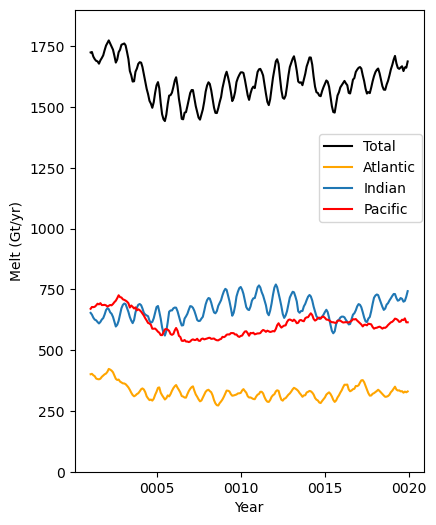

In [10]:
atlanticpI =dspI.where((-65<coords1.XC) & (coords1.XC<=40))
indianpI =dspI.where((40<coords1.XC) & (coords1.XC<=162))
pacificpI = dspI.where(((162<coords1.XC) & (coords1.XC<=250)) | (coords1.XC<=-65))

plt.figure(figsize=(4.5,6))
(-dspI.SHIfwFlx*coords1.rA/1e12*3.154e7).sum(dim=['j','i']).plot(color='black')
(-atlanticpI.SHIfwFlx*coords1.rA/1e12*3.154e7).sum(dim=['j','i']).plot(color='orange')
(-indianpI.SHIfwFlx*coords1.rA/1e12*3.154e7).sum(dim=['j','i']).plot(c='C0')
(-pacificpI.SHIfwFlx*coords1.rA/1e12*3.154e7).sum(dim=['j','i']).plot(color='red')
plt.xlabel('Year')
plt.ylabel('Melt (Gt/yr)')
#plt.title('CM4 PI Melt')
plt.ylim([0,1900])
plt.legend(('Total','Atlantic','Indian','Pacific'),loc=[0.7,0.54])

<GeoAxes: >

<Figure size 640x480 with 0 Axes>

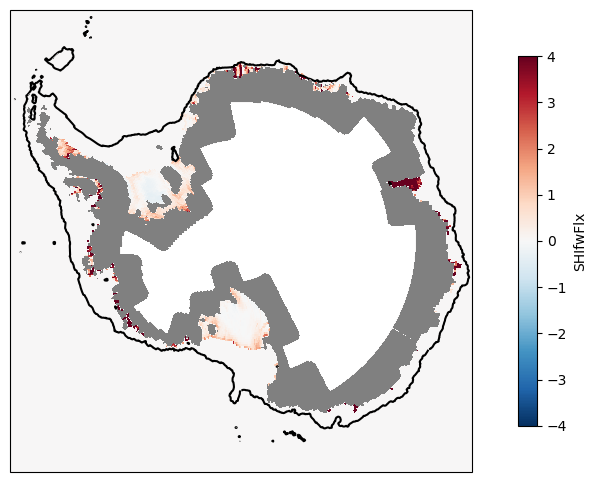

In [77]:
plt.figure()
mapper1(-dspI.SHIfwFlx.fillna(0).mean(dim='time')*365.25*86400/917,cmap='RdBu_r',vmin=-4,vmax=4)
#plt.title('Melt Rate (m/yr)') 